In [1]:
import warnings

warnings.filterwarnings("ignore")

import os
hf = r'../outputs/3.3_market_pressure_analysis/'
os.makedirs(hf, exist_ok=True)

# 3.3 Market Pressure Analysis 

In the chapter Central Place Analysis, spatial economics metrics were calculated, including demand–capacity pressure for each market area. The task of the chapter Market Pressure Analysis is to move from numerical characteristics to spatial ones and to calculate the local pressure on the student housing market and particular student accommodations.

## Set Up

Import Libraries 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import matplotlib.patheffects as path_effects
from matplotlib.colors import ListedColormap
from shapely.ops import unary_union
import rasterio
from rasterio import features
from affine import Affine
from scipy.ndimage import gaussian_filter

Colors

In [3]:
color_palettes = {
    "Mint": ["#EAF4E8", "#C8E0D4", "#A9CCC1", "#8FB9AE", "#76A79D", "#5F968E", "#498581"], 
    "Pi": ["#F8EDEB", "#FAE1DD", "#FCD5CE", "#FEC5BB", "#F8AD9D", "#F4978E", "#F08080"],
    "Or": ["#FFE5D9", "#FFD7BA", "#FEC89A", "#FFB78F", "#F49F7D", "#F28B6D"], 
    "MintPi": ["#76A79D", "#8FB9AE", "#A9CCC1", "#C8E0D4", "#FBF0EA", "#FCD5CE", "#FEC5BB", "#F8AD9D", "#F4978E"],
    "MintOr": ["#76A79D", "#8FB9AE", "#A9CCC1", "#C8E0D4", "#FBF0EA", "#FFD7BA", "#FEC89A", "#FFB78F", "#F28B6D"],
    "GrSc":  ["#434343", "#666666", "#999999", "#b7b7b7", "#cccccc", "#d9d9d9", "#efefef", "#f3f3f3", "#ffffff"]
}

cmap_mint = LinearSegmentedColormap.from_list("Mint", color_palettes["Mint"])
cmap_pi = LinearSegmentedColormap.from_list("Pi", color_palettes["Pi"])
cmap_or = LinearSegmentedColormap.from_list("Or", color_palettes["Or"])
cmap_mintpi = LinearSegmentedColormap.from_list("MintPi", color_palettes["MintPi"])
cmap_mintor = LinearSegmentedColormap.from_list("MintOr", color_palettes["MintOr"])
cmap_grsc = LinearSegmentedColormap.from_list("GrSc", color_palettes["GrSc"])

Font

In [4]:
plt.rcParams["font.family"] = "Helvetica"

Berlin Spatial Boundaries

In [5]:
pf = r"../inputs/3.3_market_pressure_analysis/lor_pgr.gpkg"
pgr = gpd.read_file(pf)
pgr.replace({'-': np.nan, 0: np.nan, '': np.nan}, inplace=True)

bf = r"../inputs/3.3_market_pressure_analysis/adm_bz.gpkg"
bz = gpd.read_file(bf)
bz.replace({'-': np.nan, 0: np.nan, '': np.nan}, inplace=True)

of = r"../inputs/3.3_market_pressure_analysis/adm_out.gpkg"
out = gpd.read_file(of)
out.replace({'-': np.nan, 0: np.nan, '': np.nan}, inplace=True)

Data Import

In [6]:
ff = r"../inputs/3.3_market_pressure_analysis/market_area_central_place_analysis.gpkg"
market_area = gpd.read_file(ff)

cf = r"../inputs/3.3_market_pressure_analysis/central_places.gpkg"
central_places = gpd.read_file(cf)

pf = r"../inputs/3.3_market_pressure_analysis/pbsa_capacity_analysis.gpkg"
pbsa_cap = gpd.read_file(pf)

# Overlap Problem

Whereas in the original Central Place, theory market areas do not overlap, in order to analyse the aggregate market pressure on the student housing market, it is necessary to move from the overlapping market areas obtained as a result of the Central Place Analysis (Figure XX) to a more accurate local structure that reflects the aggregate pressure on a particular part of the city.

In [7]:
market_area['demand_capacity_pressure_rank'] = pd.qcut(
    market_area['demand_capacity_pressure'],
    q=5, labels=range(1, 6)   # 1‑5 classes
)

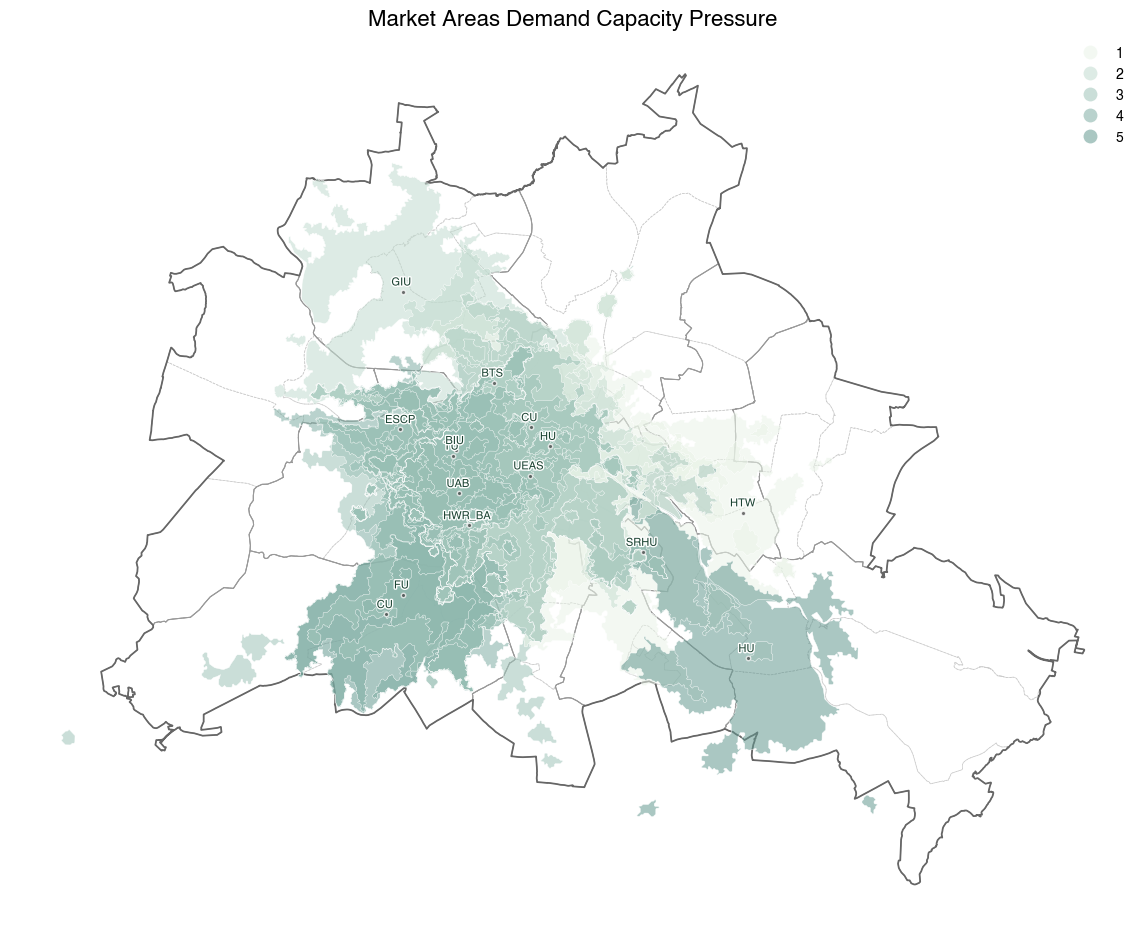

In [8]:
cmap_mint_mini = ListedColormap(cmap_mint(np.linspace(0.15, 1, 256)))

fig, ax = plt.subplots(figsize=(12, 12))

pgr.plot(ax=ax, facecolor='none', edgecolor='#cccccc', linewidth=0.5, linestyle="--")
bz.plot(ax=ax, facecolor='none', edgecolor='#999999', linewidth=0.75)
out.plot(ax=ax, facecolor='none', edgecolor='#666666', linewidth=1.25)

vmin=0
vmax=5

market_area.plot(
    ax=ax,
    column='demand_capacity_pressure_rank',
    cmap=cmap_mint,
    edgecolor='none',
    linewidth=0.3,
    alpha=0.55,
    legend=True,
    legend_kwds={'frameon': False}, 
    label = 'demand capacity pressure rank', 
    vmax = vmax)  # Matching Previous plott

plt.tight_layout()

# sm = plt.cm.ScalarMappable(cmap=cmap_mint_mini, norm=plt.Normalize(vmin, vmax))
# cbar = fig.colorbar(sm, ax=ax, shrink=0.6)
# cbar.set_label("demand capacity pressure")
# cbar.set_ticks(range(vmin, 6))
# cbar.outline.set_visible(False)

market_area.plot(
    ax=ax,
    edgecolor='white',  # variable for colormap
    facecolor="none",        # transparent polygons  # edge colors from your column
    linewidth=0.3,
    alpha=1
)
plt.tight_layout()

central_places.plot(ax=ax,
           color='#434343',
           markersize= 10,
           alpha=0.75,
           edgecolor='white',
           linewidth=1)
plt.tight_layout()
for idx, row in central_places.iterrows():
    offset = 3  # vertical offset in points
    ax.annotate(
        row['abr'],  # abbreviation
        xy=(row.geometry.x, row.geometry.y),  # position of the point
        xytext=(0, offset),  # move text upward
        textcoords='offset points',
        color='#1b4332',     # dark mint / forest green for good contrast
        fontsize=8,
        ha='center',
        va='bottom',
        alpha=1,
        zorder=6,
        path_effects=[
            path_effects.Stroke(linewidth=2, foreground='white'),
            path_effects.Normal()
        ]
    )

ax.set_title('Market Areas Demand Capacity Pressure', fontsize=16, weight='bold')
ax.set_axis_off()

save_path = os.path.join(hf, "Market_Areas_Demand_Capacity_Pressure.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")

plt.show()

*Figure XX. Market Areas Demand Capacity Pressure Rank*    

Market Areas Demand Capacity Pressure Rank (Figure XX) illustrates that each university forms its own accessibility zone, and these zones naturally overlap. On the one hand, this overlap reflects the real competition for student flows for the same housing stock. On the other hand, it creates analytical complexity: some territories are part of several market areas at the same time, which complicates the interpretation of local pressure.

This is partly due to the fact that, initially, isochrones were calculated using multipolygons, which form complex geometries and consist of several polygon parts. These fragments overlap with each other and with the polygons of other universities.

According to the results of spatial analysis, individual market areas of overlap and are part of at least five different market areas, while particularly central areas, such as parts of the Mitte district, are part of 14 market areas simultaneously. In order to simplify such a dense network of intersecting zones of influence, it is necessary to eliminate overlaps.

In [9]:
market_area['er_overlap'] = 0

# Calculate overlaps
for i, current_poly in market_area.iterrows():
    overlap_count = 0
    for j, other_poly in market_area.iterrows():
        if i != j:  # Don't compare with itself
            if current_poly.geometry.intersects(other_poly.geometry):
                overlap_count += 1
    market_area.at[i, 'er_overlap'] = overlap_count

print(f"Overlap Counts Range for Market Areas: {market_area['er_overlap'].min()} to {market_area['er_overlap'].max()}")

ff = r'../outputs/3.3_market_pressure_analysis/market_areas_not_explode_overlap.gpkg'
market_area.to_file(ff, driver="GPKG")

Overlap Counts Range for Market Areas: 5 to 14


One way to simplify geometry is to divide complex multipolygon geometry into simple polygons `market_area.explode(ignore_index=True)`. In this case, polygons intersect between 0 and 51 times.

In [10]:
market_area_exp = market_area.explode(ignore_index=True)

market_area_exp['er_overlap'] = 0

for i, current_poly in market_area_exp.iterrows():
    overlap_count = 0
    for j, other_poly in market_area_exp.iterrows():
        if i != j:  
            if current_poly.geometry.intersects(other_poly.geometry):
                overlap_count += 1
    market_area_exp.at[i, 'er_overlap'] = overlap_count

print(f"Overlap Counts Range for Exploded Market Areas: {market_area_exp['er_overlap'].min()} to {market_area_exp['er_overlap'].max()}")

Overlap Counts Range for Exploded Market Areas: 0 to 51


This means that in order to switch to simple geometry, it will be necessary to apply the division 51 more times. Such a task is not only difficult in terms of computing power, but will also result in the resulting non-intersecting polygons being extremely small.

# Rasterisation 

Another way to eliminate the problem of multiple market area overlaps is to switch from vector geometry to raster representation, i.e., to a regular grid of fixed size. Rasterisation allows complex, overlapping polygons to be replaced with a set of uniform pixel cells. Unlike a vector model, where a single territory can belong to several market areas at once, a raster grid forces a unique spatial correspondence: one cell equals one pressure value.

The use of a regular 25-meter grid provides a sufficient level of spatial detail to identify micro-zones of local congestion, especially in areas where the density of universities and student accommodation is highest.

In [11]:
value_col = "demand_capacity_pressure"

# Define raster resolution (in meters)
resolution = 25 

# Bounding box
minx, miny, maxx, maxy = market_area.total_bounds

# Create transform (affine)
transform = Affine.translation(minx, maxy) * Affine.scale(resolution, -resolution)

# Calculate raster shape
width = int((maxx - minx) / resolution)
height = int((maxy - miny) / resolution)

In [12]:
raster = np.zeros((height, width), dtype=np.float32)

# For each polygon, add pressure values
for _, row in market_area.iterrows():
    shapes = [(row.geometry, row[value_col])]
    layer = features.rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=transform,
        fill=0,
        all_touched=True,
        dtype=np.float32
    )
    raster += layer

# Demand Capacity Pressure

Thus, rasterisation can be used to assess Market Areas Local Demand Capacity Pressure (Figure XX).

The Local Demand–Capacity Pressure (Figure XX) shows the spatial distribution of the total market pressure arising from the overlap of the catchment areas of all universities. Unlike capacity–demand pressure, which is calculated at the level of individual market areas, this visualisation shows the ‘accumulated’ pressure, reflecting the cumulative effect of student competition for housing resources at each point in the urban area.

The most intense pressure zones are marked in saturated red shades and are concentrated in the central part of the city — primarily in the districts of Mitte, Charlottenburg-Wilmersdorf, and Friedrichshain-Kreuzberg. This core coincides with the spatial location of the largest educational clusters: the University of the Arts Berlin (UAB), University of Europe for Applied Sciences (UEAS), Berlin International University (BIU), Berlin School of Technology (BTS), and School of Economics and Law (HWR_BA). The catchment areas of these universities overlap most densely, which greatly increases the pressure on the limited housing stock in the central districts. It is here that local pressure reaches its maximum values — over 30, which indicates extremely high competition among international students for available places. 

As move away from the central core, the intensity of the pressure gradually decreases, transitioning into moderate greenish hues. However, the decrease is asymmetrical: in the south-west (Steglitz-Zehlendorf), south-east (Treptow-Köpenick), and partly in the north-east (Pankow), there are still local areas of increased local pressure caused by the influence of the large universities FU, HU, and HTW. At the same time, the districts of Reinickendorf, Spandau, and Marzahn-Hellersdorf show the lowest local pressure values, indicating weak involvement in competition for housing stock and relatively low attractiveness for students.

Thus, the local demand–capacity pressure map clearly shows that market tension in the student housing market in Berlin is concentrated and polycentric, reaching its peak in the central ‘education corridor’ and gradually weakening towards the periphery. 

Importantly, this visualisation emphasises that the pressure is not generated by individual market areas, but by the overlap of multiple accessibility zones, which explains why it is the concentration of university functions — and not just the local shortage of student accommodation — that is the key driver of market pressure in the central areas of the city.

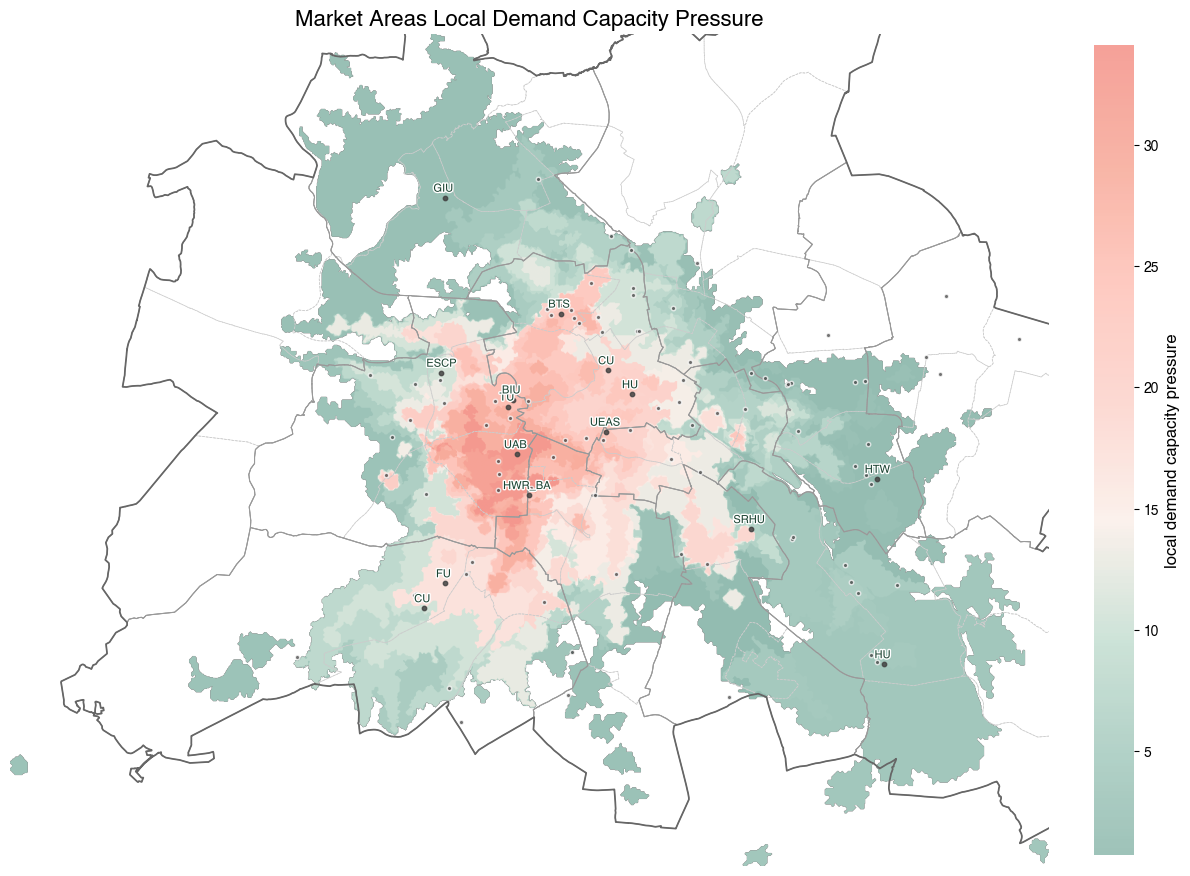

In [13]:
fig, ax = plt.subplots(figsize=(12, 12))
extent = (minx, maxx, miny, maxy)

cmap_mintpi_mini = ListedColormap(cmap_mintpi(np.linspace(0.15, 1, 256)))


# Replace pgr, bz, out with your base layers if needed
pgr.plot(ax=ax, facecolor='none', edgecolor='#cccccc', linewidth=0.5, linestyle="--")
bz.plot(ax=ax, facecolor='none', edgecolor='#999999', linewidth=0.75)
out.plot(ax=ax, facecolor='none', edgecolor='#666666', linewidth=1.25)


#-----------------------------1-------------------------------------

central_places.plot(ax=ax,
           color='#434343',
           markersize= 10,
           alpha=0.85,
           edgecolor=None,
           linewidth=1)
plt.tight_layout()
for idx, row in central_places.iterrows():
    offset = 3  # vertical offset in points
    ax.annotate(
        row['abr'],  # abbreviation
        xy=(row.geometry.x, row.geometry.y),  # position of the point
        xytext=(0, offset),  # move text upward
        textcoords='offset points',
        color='#1b4332',     # dark mint / forest green for good contrast
        fontsize=8,
        ha='center',
        va='bottom',
        alpha=1,
        zorder=6,
        path_effects=[
            path_effects.Stroke(linewidth=2, foreground='white'),
            path_effects.Normal()
        ]
    )

#-----------------------------2-------------------------------------  
pbsa_cap.plot(ax=ax,
           color='#434343',
           markersize= 10,
           alpha=0.75,
           edgecolor='white',
           linewidth=1)

#-----------------------------3-------------------------------------  
                  
masked_raster = np.ma.masked_where(raster == 0, raster)

im = ax.imshow(
    masked_raster,
    cmap=cmap_mintpi_mini,
    alpha=0.9,
    zorder=1
)

ax.imshow(masked_raster, cmap=cmap_mintpi_mini, extent=extent) #, extent=extent
ax.set_title('Market Areas Local Demand Capacity Pressure', fontsize=16, weight='bold')
ax.axis('off') 

cbar = plt.colorbar(im, ax=ax, fraction=0.036, pad=0.04)
cbar.set_label('local demand capacity pressure', fontsize=12)
cbar.outline.set_visible(False)  # cleaner look

save_path = os.path.join(hf, "Market Areas Local Demand Capacity Pressure.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")

plt.tight_layout()
plt.show()
ax.set_axis_off()

*Figure XX. Market Areas Local Demand Capacity Pressure*

In [14]:
out_raw = r'../outputs/3.3_market_pressure_analysis/market_pressure_sum_raw.tif'

# Student Accommodation Pressure

Data Import

In [15]:
out_raw = r'../outputs/3.3_market_pressure_analysis/market_pressure_sum_raw.tif'

with rasterio.open(out_raw) as src:
    raster = src.read(1)  # read first band as numpy array
    transform = src.transform
    crs = src.crs

ef = r"../inputs/3.3_market_pressure_analysis/pbsa_capacity_analysis.gpkg"
pbsa_cap = gpd.read_file(ef)

pbsa_cap.drop(columns=['link', '!cap_slag', '!cap_std', '!cap_slag_std', 'cluster', 'model', 'color', 'city'], inplace=True, errors='ignore') 

In [16]:
coords = [(geom.x, geom.y) for geom in pbsa_cap.geometry]
with rasterio.open(out_raw) as src:
    pbsa_cap["local_demand_capacity_pressure"] = [val[0] for val in src.sample(coords)]

pbsa_cap["local_demand_capacity_pressure"] = pbsa_cap["local_demand_capacity_pressure"].round(3)

Less Pressured Student Accommodations:

In [17]:
pbsa_cap[pbsa_cap["local_demand_capacity_pressure"] > 0][[
    "name",
    "plz",
    "ownership",
    "!cap",
    "ownership_model",
    "cluster_cap",
    "local_demand_capacity_pressure",
]].sort_values("local_demand_capacity_pressure").head(10)

,name,plz,ownership,!cap,ownership_model,cluster_cap,local_demand_capacity_pressure
86,Walter-Friedländer-Straße Pankow,10249,Berlinovo,285.0,State-Owned,HL,0.738
37,Storckower Straße Lichtenberg I,10369,Berlinovo,141.0,State-Owned,HL,0.738
31,Rhinstraße Lichtenberg,10315,Berlinovo,800.0,State-Owned,HH,1.167
55,WH Aristotelessteig,10318,Studierendenwerk Berlin,913.0,State-Owned,HH,1.167
54,WH Allee der Kosmonauten,10315,Studierendenwerk Berlin,298.0,State-Owned,HH,1.167
42,Studentenwohnheim Alfred-Jung-Straße,10369,Home in Berlin GmbH,800.0,Privat-Owned,HH,1.167
8,Elfriede-Tygör-Straße,10319,Berlinovo,202.0,State-Owned,HL,1.167
11,Friedenhorster Straße Friedrichsfelde,10319,Berlinovo,138.0,State-Owned,HL,1.167
80,WH Sewanstraße,10319,Studierendenwerk Berlin,700.0,State-Owned,HH,1.167
83,WH Storkower Straße (Ferdinand Thomas),10367,Studierendenwerk Berlin,508.0,State-Owned,HH,1.595


*Table XX. Less Pressured Student Accommodations*

In [18]:
pbsa_cap[pbsa_cap["local_demand_capacity_pressure"] > 0][[
    "name",
    "plz",
    "ownership",
    "!cap",
    "ownership_model",
    "cluster_cap",
    "local_demand_capacity_pressure",
]].sort_values("local_demand_capacity_pressure", ascending=False).head(10)

,name,plz,ownership,!cap,ownership_model,cluster_cap,local_demand_capacity_pressure
2,Am Mühlenberg,10825,Gewobag,158.0,State-Owned,LL,34.094002
15,Insider Apartments Berliner Straße,10715,Insider Apartment Community Living GmbH,200.0,Privat-Owned,LL,33.355999
63,WH Düsseldorfer Straße,10719,Studierendenwerk Berlin,73.0,State-Owned,LL,31.245001
78,WH Pfalzburgerstraße,10717,Studierendenwerk Berlin,28.0,State-Owned,LL,31.245001
62,WH Derfflingerstraße (Haus Unger),10785,Studierendenwerk Berlin,143.0,State-Owned,LL,28.344000
81,WH Siegmunds Hof,10555,Studierendenwerk Berlin,590.0,State-Owned,LH,28.344000
17,Insider Apartments Leibniz Straße,10625,Insider Apartment Community Living GmbH,200.0,Privat-Owned,LL,28.344000
76,WH Nollendorfstraße,10777,Studierendenwerk Berlin,183.0,State-Owned,LL,28.344000
70,WH Hardenbergstraße,10623,Studierendenwerk Berlin,46.0,State-Owned,LL,28.344000
47,Studentenwohnheim Walter-May-Haus,13353,Home in Berlin GmbH,276.0,Privat-Owned,NS,27.153999


*Table XX. Most Pressured Student Accommodations*

большое давнение прихолитьмя именно на Studierendenwerk Berlin - госудавсвенные общежития

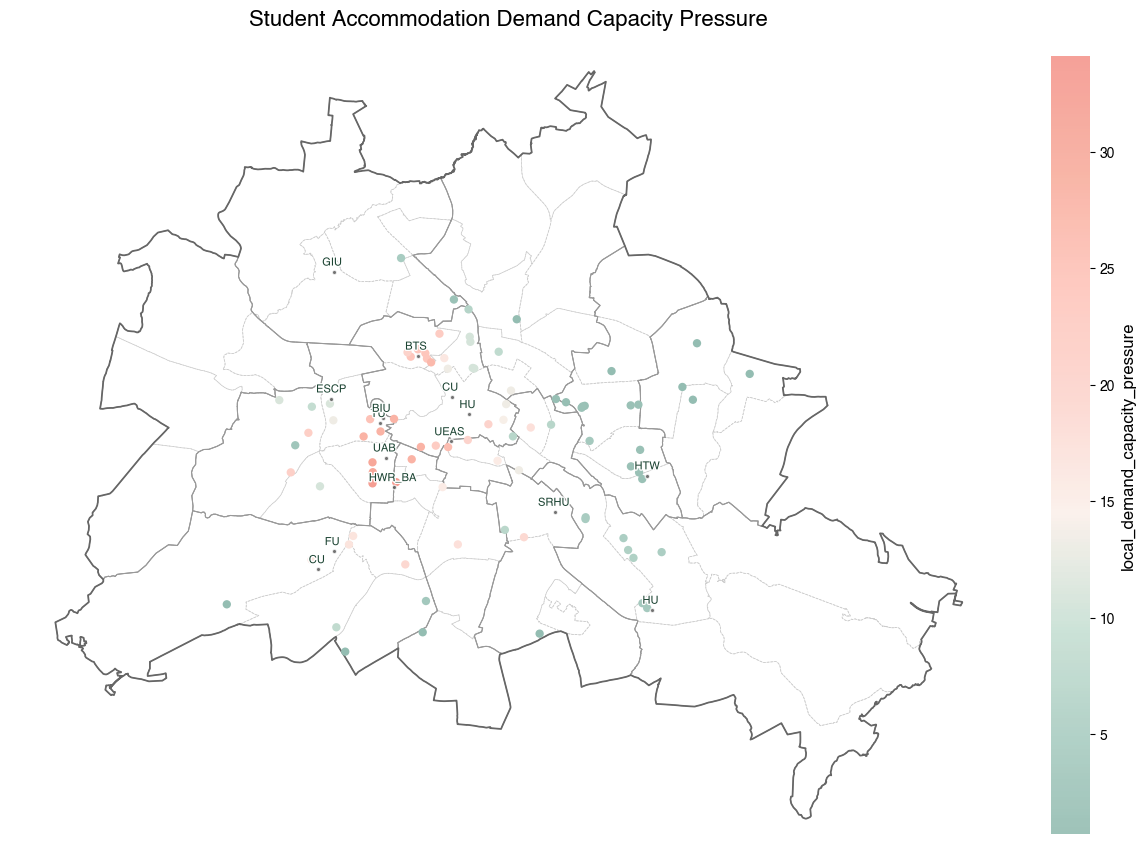

In [19]:
cmap_mint_mini = ListedColormap(cmap_mint(np.linspace(0.15, 1, 256)))

fig, ax = plt.subplots(figsize=(12, 12))

# Replace pgr, bz, out with your base layers if needed
pgr.plot(ax=ax, facecolor='none', edgecolor='#cccccc', linewidth=0.5, linestyle="--")
bz.plot(ax=ax, facecolor='none', edgecolor='#999999', linewidth=0.75)
# for idx, row in bz.iterrows():
#     centroid = row['geometry'].centroid
#     txt = ax.text(
#         centroid.x, centroid.y,
#         str(row['namgem']),
#         fontsize=8, color='#666666', ha='center', va='center'
#     )
#     txt.set_path_effects([
#         path_effects.Stroke(linewidth=2, foreground='white'),
#         path_effects.Normal()
#     ])
out.plot(ax=ax, facecolor='none', edgecolor='#666666', linewidth=1.25)

vmin=0
vmax=35

pbsa_cap.plot(
    ax=ax,
    column='local_demand_capacity_pressure',
    cmap=cmap_mintpi_mini,
    edgecolor='none',
    linewidth=0.3,
    alpha=1,
    legend=False,
    vmin = vmin,
    vmax = vmax)  # Matching Previous plott

plt.tight_layout()

cbar = plt.colorbar(im, ax=ax, fraction=0.036, pad=0.04)
cbar.set_label('local_demand_capacity_pressure', fontsize=12)
cbar.outline.set_visible(False)  # cleaner look

# sm = plt.cm.ScalarMappable(cmap=cmap_mintpi_mini, norm=plt.Normalize(vmin, vmax))
# cbar = fig.colorbar(sm, ax=ax, shrink=0.6)
# cbar.set_label("summed demand capacity pressure")
# cbar.set_ticks(range(vmin, 36))

# for _, r in market_area.iterrows():
#     ax.annotate(str(int(r["cntr_hierracy_rank"])), 
#                 xy=r["geometry"].representative_point().coords[0],
#                 ha="center", va="center", fontsize=7)

# market_area.plot(
#     ax=ax,
#     edgecolor='white',  # variable for colormap
#     facecolor="none",        # transparent polygons  # edge colors from your column
#     linewidth=0.3,
#     alpha=1
# )
plt.tight_layout()

central_places.plot(ax=ax,
           color='#434343',
           markersize= 10,
           alpha=0.75,
           edgecolor='white',
           linewidth=1)
plt.tight_layout()
for idx, row in central_places.iterrows():
    offset = 3  # vertical offset in points
    ax.annotate(
        row['abr'],  # abbreviation
        xy=(row.geometry.x, row.geometry.y),  # position of the point
        xytext=(0, offset),  # move text upward
        textcoords='offset points',
        color='#1b4332',     # dark mint / forest green for good contrast
        fontsize=8,
        ha='center',
        va='bottom',
        alpha=1,
        zorder=6,
        path_effects=[
            path_effects.Stroke(linewidth=2, foreground='white'),
            path_effects.Normal()
        ]
    )

#ax.legend(handles=legend_elements, loc='lower center', ncol=5, frameon=False, prop={'size': 10})
ax.set_title('Student Accommodation Demand Capacity Pressure', fontsize=16, weight='bold')
ax.set_axis_off()

save_path = os.path.join(hf, "Student Accommodation Demand Capacity Pressure.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")

plt.show()

*Figure XX. Student Accommodation Demand Capacity Pressure*